# ABOUT:
- this notebook, 
    - compared different categorical encoding techniques
- insights:
    - in experiments here, best performing encoder was **WOEEncoder**, followed by TargetEncoder, SimilarityEncoder, OneHotEncoder  
    - however, upon evaluating WOEEncoder on test set, performance was extremely poor. **WOEEncoder led to severe overfitting**.
- more study needs to be done in future to figure out how to avoid overfitting when using Encoders

### Import data

In [3]:
import pandas as pd
train_features = pd.read_csv(r"C:\Users\tanch\Documents\Coding Competitions\DataDriven\Flu Shot Learning\local\data\training_set_features.csv")
train_labels = pd.read_csv(r"C:\Users\tanch\Documents\Coding Competitions\DataDriven\Flu Shot Learning\local\data\training_set_labels.csv")
cat_features = ['race',"hhs_geo_region",'employment_industry', 'employment_occupation',"age_group","education","employment_status","census_msa" ]

In [6]:
X = train_features[cat_features]
y = train_labels['h1n1_vaccine']
X

,race,hhs_geo_region,employment_industry,employment_occupation,age_group,education,employment_status,census_msa
0,White,oxchjgsf,NaN,NaN,55 - 64 Years,< 12 Years,Not in Labor Force,Non-MSA
1,White,bhuqouqj,pxcmvdjn,xgwztkwe,35 - 44 Years,12 Years,Employed,"MSA, Not Principle City"
2,White,qufhixun,rucpziij,xtkaffoo,18 - 34 Years,College Graduate,Employed,"MSA, Not Principle City"
3,White,lrircsnp,NaN,NaN,65+ Years,12 Years,Not in Labor Force,"MSA, Principle City"
4,White,qufhixun,wxleyezf,emcorrxb,45 - 54 Years,Some College,Employed,"MSA, Not Principle City"
...,...,...,...,...,...,...,...,...
26702,White,qufhixun,NaN,NaN,65+ Years,Some College,Not in Labor Force,Non-MSA
26703,White,lzgpxyit,fcxhlnwr,cmhcxjea,18 - 34 Years,College Graduate,Employed,"MSA, Principle City"
26704,White,lzgpxyit,NaN,NaN,55 - 64 Years,Some College,NaN,"MSA, Not Principle City"
26705,Hispanic,lrircsnp,fcxhlnwr,haliazsg,18 - 34 Years,Some College,Employed,Non-MSA


## Implement categorical encoding - xgboost 

In [7]:
from dirty_cat import SimilarityEncoder, TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.woe import WOEEncoder
from category_encoders.hashing import HashingEncoder
from category_encoders.count import CountEncoder
import xgboost as xgb

In [8]:
encoders_dict = {
    'OneHotEncoder': OneHotEncoder(sparse=False),
    'SimilarityEncoder': SimilarityEncoder(similarity='ngram'),
    'TargetEncoder': TargetEncoder(),
    'WOEEncoder': WOEEncoder(),
    "OrdinalEncoder":OrdinalEncoder(),
    "CatBoostEncoder" :CatBoostEncoder(),
    "CountEncoder": CountEncoder(),
    "HashingEncoder":HashingEncoder()
}

In [260]:
params = {
    "learning_rate" :0.1,
    #"n_estimators":1000,
    "max_depth":5,
    "min_child_weight":1,
    "gamma":0,
    "subsample":0.8,
    "colsample_bytree":0.8,
    "objective": 'binary:logistic',
    "nthread":-1,
    "scale_pos_weight":1,
    "seed":0
}

In [261]:
encoders_performance = {}
for encoder_name, encoder in encoders_dict.items():
    encoded_features = encoder.fit_transform(train_features[cat_features],y)
    model = xgb.XGBClassifier()
    model.set_params(**params)
    xgtrain = xgb.DMatrix(data = encoded_features, label=y) 
    cvresult = xgb.cv(params = params, 
                      dtrain  = xgtrain, 
                      num_boost_round=300, 
                      nfold=5,
                      metrics='auc', 
                      stratified = True,
                      early_stopping_rounds=50,
                      seed = 0)
    encoders_performance[encoder_name] = cvresult["test-auc-mean"].max()

C:\Users\tanch\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


## Results 
- **best performing encoder on xgboost was WOEEncoder**, followed by TargetEncoder, SimilarityEncoder, OneHotEncoder  

<AxesSubplot:ylabel='test-auc-mean'>

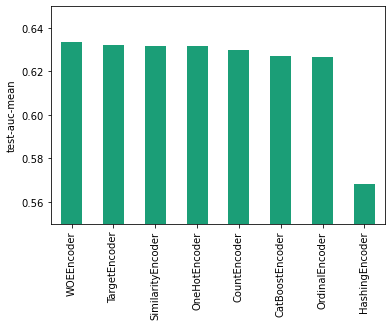

In [274]:
pd.Series(encoders_performance).sort_values(ascending=False).plot(kind='bar', ylabel="test-auc-mean",colormap = "Dark2",ylim = (0.55,0.65))

In [275]:
pd.Series(encoders_performance).sort_values(ascending=False)

WOEEncoder           0.633329
TargetEncoder        0.632311
SimilarityEncoder    0.631853
OneHotEncoder        0.631731
CountEncoder         0.629809
CatBoostEncoder      0.626914
OrdinalEncoder       0.626758
HashingEncoder       0.568023
dtype: float64

## Implement categorical encoding - catboost

In [18]:
params = {
    "learning_rate" : 0.01,
    "iterations" :  3000,
    'depth': 4, 
    'rsm': 0.2680717988907101, 
    'l2_leaf_reg': 5.087316180296697, 
    'auto_class_weights': 'Balanced',
    "loss_function" : "Logloss",
    "verbose":False,
    "task_type" : "CPU",
    "eval_metric":"AUC"
}
nfolds  = 3

In [40]:
from catboost import CatBoostClassifier, Pool, cv
def catboost_cv(X, y, params, nfolds=5, cat_features = [],early_stopping_rounds = 50,plot=False):
                
    cv_dataset = Pool(data=X,                                       # cv requires a Pool dataset
                      label=y,
                      cat_features = cat_features)
    scores = cv(cv_dataset,                                          # perform cv
                params,
                fold_count=nfolds, 
                plot=plot,
                verbose=False,
                early_stopping_rounds = early_stopping_rounds,
                seed = 0)                                       # return best iteration
    
    return scores["test-AUC-mean"].max()

In [36]:
encoders_performance= {}

In [37]:
for encoder_name, encoder in encoders_dict.items():
    encoded_X = encoder.fit_transform(X,y)
    encoders_performance[f"catboost_{encoder_name}"] = catboost_cv(encoded_X,y,params)

Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)


C:\Users\tanch\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)
Stopped by overfitting detector  (50 iterations wait)


## Results 
- **best performing encoder on catboost was also WOEEncoder**, followed by TargetEncoder, SimilarityEncoder, OneHotEncoder  

<AxesSubplot:ylabel='test-auc-mean'>

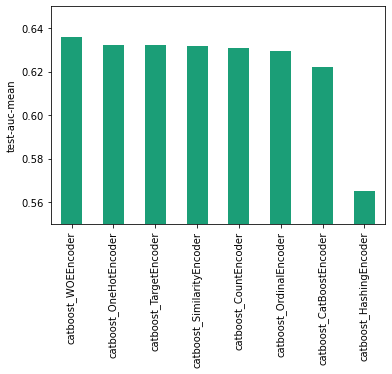

In [54]:
pd.Series(encoders_performance).sort_values(ascending=False).plot(kind='bar', ylabel="test-auc-mean",colormap = "Dark2",ylim = (0.55,0.65))

In [58]:
pd.Series(encoders_performance).sort_values(ascending=False)

catboost_WOEEncoder           0.636045
catboost_OneHotEncoder        0.632235
catboost_TargetEncoder        0.632014
catboost_SimilarityEncoder    0.631801
catboost_CountEncoder         0.630939
catboost_OrdinalEncoder       0.629454
catboost_CatBoostEncoder      0.621920
catboost_HashingEncoder       0.564964
dtype: float64

## What about specifying cat_features for catboost?
- specifying cat_features for catboost has **significantly longer runtime** as there performs feature engineering internally
- the performance was good at 0.633, but **still behind WOEEncoder, 0.636**

In [56]:
encoded_X = OrdinalEncoder().fit_transform(X,y)
catboost_cv(encoded_X,y,params,cat_features=cat_features)

Stopped by overfitting detector  (50 iterations wait)


0.6330133246846695

## Diving deeper into WOEEncoder
- **"randomized"=False (default) works slightly better**
- **"regularization"=1 is (default) seem to work best**

In [66]:
encoders_performance= {}

In [67]:
WOEEncoder_settings = [{"randomized":False},
                       {"randomized":True}]
for setting in WOEEncoder_settings:
    encoder = WOEEncoder(**setting)
    encoded_X = encoder.fit_transform(X,y)
    encoders_performance[f"{setting}"] = catboost_cv(encoded_X,y,params)

C:\Users\tanch\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Stopped by overfitting detector  (50 iterations wait)


C:\Users\tanch\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Stopped by overfitting detector  (50 iterations wait)


In [70]:
encoders_performance

{"{'randomized': False}": 0.6360450040935605,
 "{'randomized': True}": 0.6340910655341943}

In [83]:
encoders_performance= {}

In [89]:
for regularization in [0,0.25,0.5,0.75,1,1.25,1.5]:
    encoder = WOEEncoder(regularization=regularization)
    encoded_X = encoder.fit_transform(X,y)
    encoders_performance[regularization] = catboost_cv(encoded_X,y,params,nfolds = 5)

C:\Users\tanch\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Stopped by overfitting detector  (50 iterations wait)


C:\Users\tanch\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Stopped by overfitting detector  (50 iterations wait)


C:\Users\tanch\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Stopped by overfitting detector  (50 iterations wait)


C:\Users\tanch\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Stopped by overfitting detector  (50 iterations wait)


C:\Users\tanch\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Stopped by overfitting detector  (50 iterations wait)


C:\Users\tanch\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Stopped by overfitting detector  (50 iterations wait)


C:\Users\tanch\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Stopped by overfitting detector  (50 iterations wait)


<AxesSubplot:>

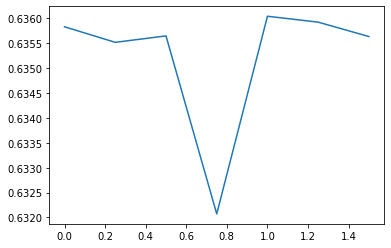

In [90]:
import seaborn as sns
sns.lineplot(x = encoders_performance.keys(),y = encoders_performance.values())

In [91]:
encoders_performance

{0: 0.6358331433980254,
 0.25: 0.6355203424028294,
 0.5: 0.6356498337836936,
 0.75: 0.6320712287974227,
 1: 0.6360450040935605,
 1.25: 0.6359262832770431,
 1.5: 0.6356368636688959}

In [257]:
def xgboost_cv_plot(X,y,params,nfold = 5, iterations= 1000, early_stopping_rounds = 50, plot = True):
    # cross validation
    model = xgb.XGBClassifier()
    model.set_params(**params)
    xgtrain = xgb.DMatrix(data = X, label=y) 
    cvresult = xgb.cv(params = params, 
                      dtrain  = xgtrain, 
                      num_boost_round=iterations, 
                      nfold=nfold,
                      metrics='auc', 
                      stratified = True,
                      early_stopping_rounds=early_stopping_rounds,
                      seed = 0)
    # print best iteration
    test_metric = "test-auc-mean"
    print(f"Best Iteration: {cvresult.shape[0]}")
    for k,v in cvresult.iloc[cvresult[test_metric].idxmax()].items():
        print(f"{k}:{v}")
    if plot:
        # plot cv results
        cvresult['iteration'] = cvresult.index
        metric_to_plot = ["train-auc-mean","test-auc-mean"]                 
        cvresult = pd.melt(cvresult,id_vars = ["iteration"], value_vars = metric_to_plot)
        sns.lineplot(data = cvresult, x = "iteration", hue = "variable", y = "value", palette = "Dark2")


In [151]:
# show_feature_importance
def show_feature_importances(model, feature_names):
    feat_imp = pd.Series(index = feature_names, data = model.feature_importances_).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances',colormap = "Dark2")